In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns

In [2]:
data = pd.read_csv('/Users/iangani/Desktop/Cervical_Cancer_Data.csv')
data = data.replace('?', np.nan)
data.drop(columns=['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], inplace=True)
data = data.apply(pd.to_numeric)
data.fillna(data.mean(), inplace=True)

X = data.drop(columns=['Biopsy']).values
y = data['Biopsy'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
def generate_age_conditions(size):
    age_distribution = [
        (35, 54, 0.5), 
        (65, 100, 0.2),
        (20, 30, 0.15),
        (0, 20, 0.15) 
    ]

    conditions = np.zeros((size, 1)) 
    for min_age, max_age, prob in age_distribution:
        num_samples = int(size * prob)
        sampled_ages = np.random.randint(min_age, max_age+1, size=num_samples)
        conditions[:num_samples] = sampled_ages.reshape(-1, 1)
        conditions = np.roll(conditions, np.random.randint(size))
    
    return conditions

num_samples = X_scaled.shape[0]
age_conditions = generate_age_conditions(num_samples)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [4]:
class CGAN_Generator(nn.Module):
    def __init__(self, input_dim, condition_dim, output_dim):
        super(CGAN_Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, noise, conditions):
        x = torch.cat([noise, conditions], 1)
        return self.model(x)
    
class CGAN_Discriminator(nn.Module):
    def __init__(self, input_dim, condition_dim):
        super(CGAN_Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, conditions):
        x = torch.cat([x, conditions], 1)
        return self.model(x)

noise_dim = 100
condition_dim = 1 
output_dim = X.shape[1] 

generator = CGAN_Generator(noise_dim, condition_dim, output_dim)
discriminator = CGAN_Discriminator(output_dim, condition_dim)

g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [5]:
epochs = 500 
for epoch in range(epochs):
    age_conditions = generate_age_conditions(X.shape[0])
    age_conditions_tensor = torch.tensor(age_conditions, dtype=torch.float32)
    
    real_labels = torch.ones(X.shape[0], 1)
    fake_labels = torch.zeros(X.shape[0], 1)
    
    d_optimizer.zero_grad()
    
    real_outputs = discriminator(X_tensor, age_conditions_tensor)
    d_loss_real = criterion(real_outputs, real_labels)

    z = torch.randn(X.shape[0], noise_dim)
    fake_data = generator(z, age_conditions_tensor)
    fake_outputs = discriminator(fake_data.detach(), age_conditions_tensor)
    d_loss_fake = criterion(fake_outputs, fake_labels)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    g_optimizer.zero_grad()
    fake_data = generator(z, age_conditions_tensor)
    outputs = discriminator(fake_data, age_conditions_tensor)
    g_loss = criterion(outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    
num_samples_to_generate = 750
conditions_repeated = np.tile(age_conditions, (num_samples_to_generate // num_samples, 1))
if conditions_repeated.shape[0] < num_samples_to_generate:
    additional_samples = num_samples_to_generate - conditions_repeated.shape[0]
    extra_conditions = generate_age_conditions(additional_samples)
    conditions_repeated = np.vstack([conditions_repeated, extra_conditions])

conditions_repeated_tensor = torch.tensor(conditions_repeated, dtype=torch.float32)

with torch.no_grad():
    z = torch.randn(num_samples_to_generate, noise_dim)
    generated_data = generator(z, conditions_repeated_tensor).numpy()

X_augmented = np.concatenate((X, generated_data))
y_generated = np.ones(generated_data.shape[0])
y_augmented = np.concatenate((y, y_generated))

In [6]:
kf = StratifiedKFold(n_splits=5)
all_y_true = []
all_y_pred = []
all_y_proba = []

for train_index, test_index in kf.split(X_augmented, y_augmented):
    X_train, X_test = X_augmented[train_index], X_augmented[test_index]
    y_train, y_test = y_augmented[train_index], y_augmented[test_index]

    model = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=50, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_proba.extend(y_proba)

Accuracy: 0.9546019900497512
Precision: 0.9765625
Recall: 0.9316770186335404
F1 Score: 0.9535918626827717
ROC AUC: 0.9385263337020335


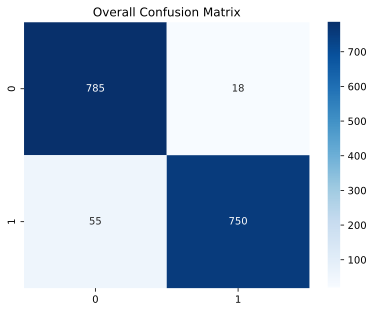

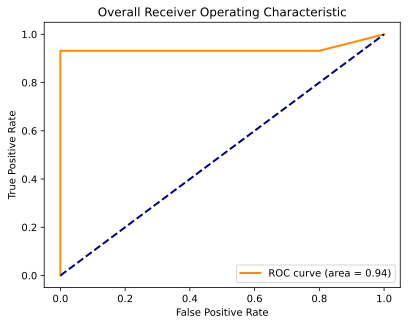

In [8]:
print("Accuracy:", accuracy_score(all_y_true, all_y_pred))
print("Precision:", precision_score(all_y_true, all_y_pred))
print("Recall:", recall_score(all_y_true, all_y_pred))
print("F1 Score:", f1_score(all_y_true, all_y_pred))
print("ROC AUC:", roc_auc_score(all_y_true, all_y_proba))

cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Overall Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(all_y_true, all_y_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(all_y_true, all_y_proba))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()